# `dIdV.ipynb`

Notebook for dIdV study fits

- didv notes:
- square wave
- 100 Hz
- 20 mV
- gain 50
- offx - QET bias in V
- Sig Gen

In [790]:
# imports
import sys
import os
import pickle
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st


# custom modules
from picoscopedata import PicoscopeData
from utilities import *


find_imports()
import qetpy as qp
import optimal_filter_utils as of


In [791]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [792]:
# read in results from IbIs analysis
runnum = 6
ibis_runname = '20250626-0002'
runname = '20250626'
folder_base = '/Users/ajbiffl/Documents/CDMS/oxford_fridge/B13 Cryolab'
#folder_base = 'C:/Users/MINER/Documents/B13 Cryolab'

with open(folder_base + f'/Run{runnum}/IbIs Data/{ibis_runname}_results.dat', 'rb') as f:
    ibis, ivfits, tr_fits = pickle.load(f)

In [793]:
import importlib
import picoscopedata
importlib.reload(picoscopedata)
from picoscopedata import PicoscopeData

# config dict
drive_path = folder_base + f'/Run{runnum}/dIdV Data'
channels = 'ACD'
fs = 1e7 # sampling frequency (Hz)
#glob_pattern = drive_path + '/' + runname + '*' + '/*.csv'
glob_pattern = drive_path + '/' + runname + '*.csv'
#print(glob_pattern)

didv = PicoscopeData(runname, drive_path, glob_pattern = glob_pattern, row_avg = 1)
#single_file = False
#if single_file:
#    didv = PicoscopeData(runname, drive_path, glob_pattern = glob_pattern, row_avg = 1, throw_nans = True)
#else:
#    didv = PicoscopeData(runname, drive_path, idx = range(12), vertical_stack = True, glob_pattern = glob_pattern, row_avg = 1, throw_nans = True)

collecting 12 files with glob
Created new PicoscopeData object with 500004 data points
Channels: ['A', 'C', 'D']


In [794]:
didv.arrs['A'][1].shape

(500004,)

In [795]:
didv.arrs[didv.channels[0]].shape

(12, 500004)

In [796]:
if 0:
    features = ["ds", "DSB", "DSstd", "bs", "dp1", "dp2", "slope_left", "slope_right"]

    all_ch_features = {ch: {f: [] for f in features} for ch in channels}

    x_left = [2500 + i * 10_000 for i in range(10)]
    x_right = [7500 + i * 10_000 for i in range(10)]
    for i in range(64*16):
        df = pd.read_csv(didv.trace_file(i), skiprows = (1,2), na_values = ["∞", "-∞"])
        for ch in channels:
            trace = df['Channel ' + ch].values
            sa = trace[2500]
            sb = trace[7500]
            s1, s2 = sorted((sa, sb))
            p2 = trace[:7500].max()
            p1 = trace[:7500].min()

            SA = trace[x_left]
            SB = trace[x_right]

            DSB = np.mean(np.abs(SB - SA))
            DSstd = np.std(SB - SA)

            slope_left = np.polyfit(x_left, SA, 1)[0]
            slope_right = np.polyfit(x_right, SB, 1)[0]

            all_ch_features[ch]["ds"].append(s2 - s1)
            all_ch_features[ch]["DSB"].append(DSB)
            all_ch_features[ch]["DSstd"].append(DSstd)
            all_ch_features[ch]["bs"].append((s1+s2)/2)
            all_ch_features[ch]["dp1"].append(s1 - p1)
            all_ch_features[ch]["dp2"].append(p2 - s2)
            all_ch_features[ch]["slope_left"].append(slope_left)
            all_ch_features[ch]["slope_right"].append(slope_right)
    for ch in channels:
        all_ch_features[ch] = pd.DataFrame(all_ch_features[ch])

In [797]:
try:
    all_ch_features_cut = {ch: pd.DataFrame() for ch in channels}

    all_ch_features_cut['A'] = all_ch_features['A'].loc[(all_ch_features['A']['ds'] > 0.55) * (abs(all_ch_features['A']['slope_right']) < 2.5e-6)]

    all_ch_features_cut['B'] = all_ch_features['B'].loc[(all_ch_features['B']['ds'] < 3) * (abs(all_ch_features['B']['bs']) < 0.1) * (abs(all_ch_features['B']['slope_right']) < 2e-6)]

    all_ch_features_cut['C'] = all_ch_features['C'].loc[(all_ch_features['C']['ds'] > 0.25) * (abs(all_ch_features['C']['slope_right']) < 2.5e-6)]

    all_ch_features_cut['D'] = all_ch_features['D'].loc[(all_ch_features['D']['ds'] > 2.5) * (abs(all_ch_features['D']['slope_right']) < 5e-6)]

    for ch in channels:
        print(f"Ch {ch}: {len(all_ch_features_cut[ch]) / 16}")
except:
    pass

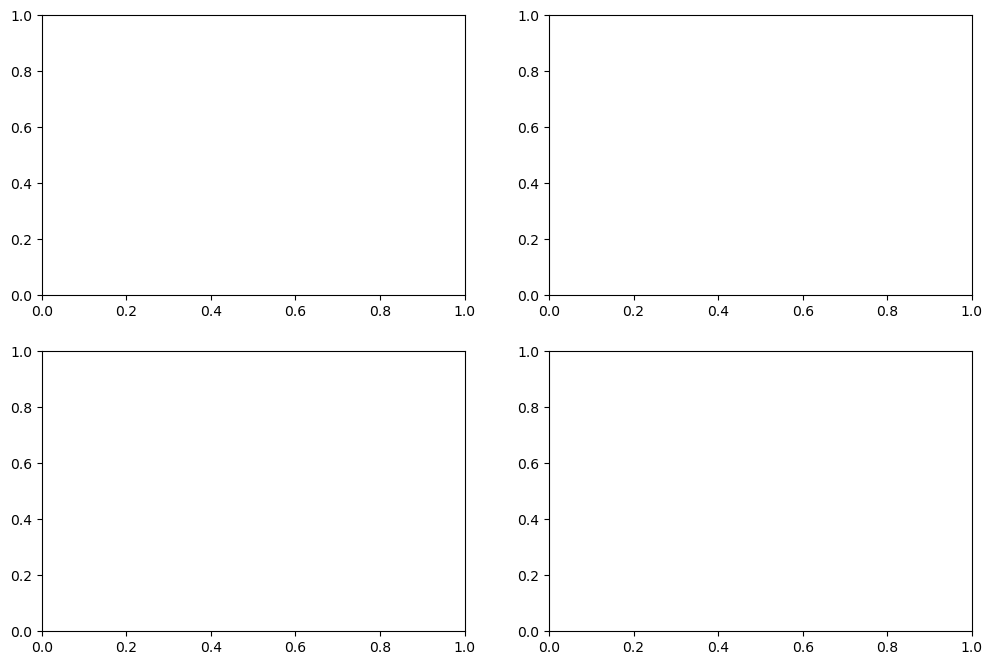

In [798]:
try:
    after_cuts = True
    if after_cuts:
        df = all_ch_features_cut
    else:
        df = all_ch_features

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
    for c, ax in zip('ABCD', axs.flatten()):
        ax.hist(np.array(df[c]['ds']), bins = 100, histtype = 'step', label = 'ds')
        ax.set_title(c)
        ax.grid()
        ax.legend()

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
    for c, ax in zip('ABCD', axs.flatten()):
        ax.hist(np.array(df[c]['DSB']), bins = 100, histtype = 'step', label = 'DSB')
        ax.hist(np.array(df[c]['DSstd']), bins = 100, histtype = 'step', label = 'DSstd')
        ax.set_title(c)
        ax.grid()
        ax.legend()

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
    for c, ax in zip('ABCD', axs.flatten()):
        ax.hist(np.array(df[c]['bs']), bins = 100, histtype = 'step', label = 'bs')
        ax.set_title(c)
        ax.set_xlim(-1,1)
        ax.grid()
        ax.legend()

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
    for c, ax in zip('ABCD', axs.flatten()):
        ax.hist(np.array(df[c]['dp2']), bins = 100, histtype = 'step', label = 'dp2')
        ax.hist(np.array(df[c]['dp1']), bins = 100, histtype = 'step', label = 'dp1')
        ax.set_title(c)
        ax.grid()
        ax.legend()

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
    for c, ax in zip('ABCD', axs.flatten()):
        ax.hist(np.array(df[c]['slope_right']), bins = 100, histtype = 'step', label = 'slope_right')
        ax.hist(np.array(df[c]['slope_left']), bins = 100, histtype = 'step', label = 'slope_left')
        ax.set_title(c)
        # ax.set_xlim(-,1)
        ax.grid()
        ax.legend()
except:
    pass

In [799]:
for c in didv.channels:
    print(c, didv(c).shape)

A (12, 500004)
C (12, 500004)
D (12, 500004)


In [800]:
didv.N, didv.ts.shape

(500004, (500004,))

In [801]:
try:
    c = 'B'
    x = didv.arrs[c]
    I,J = x.shape
    for i in range(I):
        if any(np.isnan(x[i])):
            print(i)
except:
    pass

In [802]:
didv(channels[0]).shape

(12, 500004)

In [803]:
R_ops = tr_fits.loc['R_op'].values
R_ops*1e3 # milliohms

array([1016.21742905,  662.46816558,  203.96529986,  652.51557748])

In [804]:
if 0:
    B_avg = didv('B').mean(axis=0)
    any(np.isnan(B_avg))

In [805]:
didv('A').shape

(12, 500004)

In [806]:
# purge out-of-phase traces

switchit = {'A': -1, 'B': 1, 'C': 1, 'D': 1}

for c in channels:
    meandat = didv.arrs[c].mean(axis = 0)
    ntraces = didv.arrs[c].shape[0]
    inphase = np.zeros(ntraces, dtype = bool)
    for i in range(ntraces):
        inphase[i] = (np.dot(didv.arrs[c][i], meandat)*switchit[c] > 0)

    didv.arrs[c] = didv.arrs[c][inphase,:].copy()

In [807]:
for c in channels:
    print(didv(c).shape)

(4, 500004)
(11, 500004)
(10, 500004)


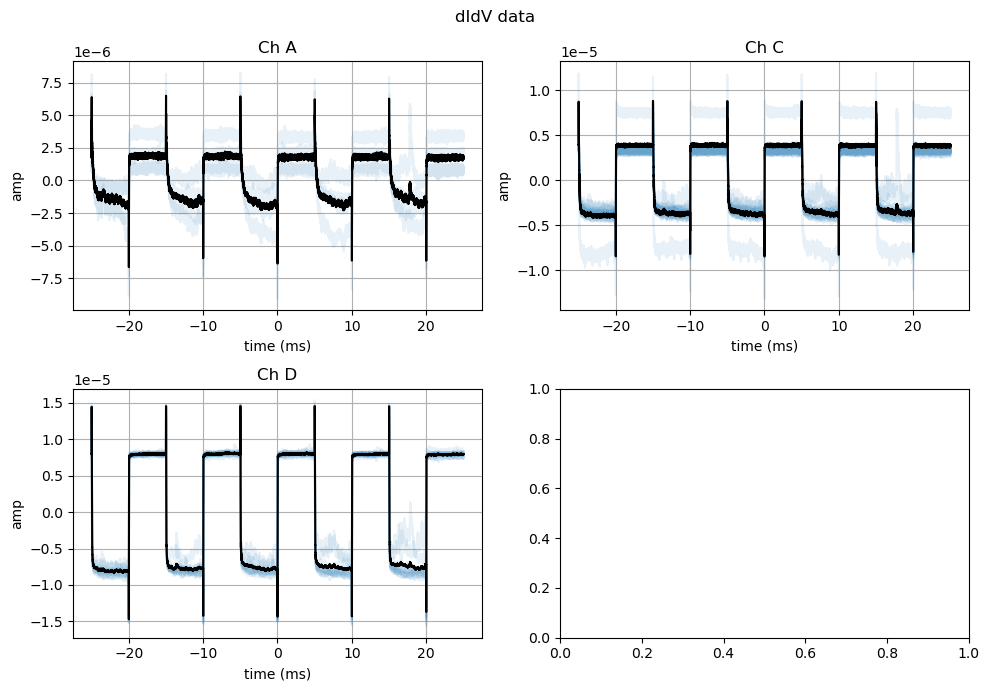

In [808]:
# plot DIDV data
numrows = (1+len(channels))//2

didv_waveform = didv('H')

fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))

fig.suptitle('dIdV data')


for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

    ax.grid()
    ax.set_ylabel('amp')
    ax.set_xlabel('time (ms)')
    ax.set_title(f'Ch {c}')

    #ax.plot(didv.ts*1e3, didv(c)[5])
    dat = didv(c)
    meandat = dat.mean(axis = 0)

    for i in range(dat.shape[0]):
        ax.plot(didv.ts*1e3, dat[i], alpha = 0.1, color = ('C0' if np.dot(dat[i], meandat) > 0 else 'r' ))
    #ax.plot(didv.ts*1e3, didv('H'), alpha = 0.2)
    #for i in range(10):
    #    ax.axvline(didv.ts[2500 + i*10_000]*1e3)
    #    ax.axvline(didv.ts[7500 + i*10_000]*1e3)
    ax.plot(didv.ts*1e3, meandat, color = 'k')
    #ax.plot(didv.ts[:100_000]*1e3, didv(c)[:100_000])
    #ax.set_ylim(-1e-6, 1e-6)
    #ax.plot(didv.ts*1e3, didv(c))

fig.tight_layout()


In [809]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offA': -194.9,
 'offC': -141.1,
 'offD': -85.5}

In [810]:
1/np.diff(didv.ts[:10])# == 1e-7

array([10000000.00005939, 10000000.00005939, 10000000.00005939,
       10000000.00005939, 10000000.00005939, 10000000.00005939,
       10000000.00005939,  9999999.99971244, 10000000.00005939])

In [811]:
np.where(np.diff(didv.ts) != 1e-7)

(array([     0,      1,      2, ..., 500000, 500001, 500002],
       shape=(499990,)),)

In [812]:
ff = 1/(((np.diff(didv.ts)).mean()))
freq = 100

ff, freq, ff/freq, didv.ts.size/10, fs

(np.float64(10000000.593996463),
 100,
 np.float64(100000.00593996463),
 50000.4,
 10000000.0)

In [813]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offA': -194.9,
 'offC': -141.1,
 'offD': -85.5}

In [814]:
didvfit = {}

## Fitting ##

In [ ]:
channels_quick = 'AD'
#best_dt0 = {'A': 1.4e-6, 'B': 1.5e-6, 'C': 1.5e-6, 'D': -1.4e-6} # doubled
best_dt0 = {'A': -5e-6, 'B': -5e-3, 'C': -5e-6, 'D': -5e-6}

for c in channels_quick:
    i = channels.find(c)
    avg = didv(c).mean(axis=0)
    didvfit[c] = qp.DIDV(
        rawtraces = didv(c)[:,:-4],
        #rawtraces = np.reshape(didv(c)[:10_000_000], (1000, 10_000))[-100:], #rawtraces = np.array([avg*1.001, avg*0.999]),
        fs = fs,#np.round(1/((np.diff(didv.ts)).mean())),
        sgfreq = didv.config['freq'],
        sgamp = func_to_ibias(didv.config['amp']),
        rsh = didv.config['rsh'],
        rp = ivfits.rp[0,i],
        dutycycle = 0.5,
        add180phase = True,
        autoresample = False,
        r0 = R_ops[i], # estimated TES resistance (Ohms)
        tracegain = 1,#(didv.config['gain'])*(10)*(1.2e3), # what to divide by to convert rawtraces to Amps (from convert_ADC)
        dt0 = best_dt0[c] # guess
        )

    didvfit[c].processtraces()


$$\tau_0=\frac{C}{G}$$

$$A=R_l+R_0(1+\beta)$$

$$B=\frac{R_0\mathcal{L}}{1-\mathcal{L}}(2+\beta)$$

$$\tau_1=\frac{C}{G(1-\mathcal{L})} = \frac{\tau_0}{1-\mathcal{L}}$$

$$\tau_2=\frac{L}{R_l + R_0(1+\beta)}$$

$$C= \frac{g_{ratio}}{1-\mathcal{L}}$$


$$R_l=R_{sh} + R_p$$

$$L = A\tau_2$$

$$\beta = \frac{A-R_l}{R_0} - 1$$

$$\mathcal{L} = \frac{B}{A + B + R_0 - R_l}$$

$$\tau_0 = \tau_1\times\frac{A+R_0-R_l}{A+B+R_0-R_l}$$

$$g_{ratio} = C\times\frac{A+R_0-R_l}{A+B+R_0-R_l}$$

In [1798]:
try:
    print([float(didvfit['C'].fitresult(3)['params'][x]) for x in ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']])
    print([float(didvfit['D'].fitresult(3)['params'][x]) for x in ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']])
except:
    pass

[0.09377046679723833, 4907184.93422695, 25289620.484983318, 423.39970484105584, 3.6544531653170124e-06, 3.627846531913408e-05, 0.0050009956276763625]
[0.15097301892948603, 34887669.02955575, 189503231.4593539, -5.065274827637161, -1.0822656155569883e-05, 1.380538032861366e-05, 0.004951287800033825]


## Calculate fits ##

In [1799]:
param_list = ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']

# fit 
fit_guesses = {
    'A': np.array([
        0.2, # A
        0.4, # B
        -0.2, # C
        3.5e-5, # tau1
        2.8e-6, # tau2
        1e-5, # tau3
        0.005005 #- 5e-3 # dt
        ]),
    'B': np.array([
        2e-05, # A
        1.7e5, # B
        -7.1e4, # C
        1e-2, # tau1
        0.23, # tau2
        1.1148e-6, #tau3
        0.005 # dt
        ]), 
    'C': np.array([
        0.2, # A
        0.4, # B
        -0.2, # C
        400, # tau1
        2.8e-3, # tau2
        1e-3, # tau3
        0.005004 #- 5e-3 # dt
        ]),
    'D': np.array([
        0.04, # A
        2.8e7, # B
        1e8, # C
        400, # tau1
        3.6e-6, # tau2
        3.6e-5, #tau3
        0.00495 #- 5e-3 # dt
        ]), 
}
bounds = {
    'A': (np.array([-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,]),
          np.array([np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,])), 
    'B': (np.array([-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,]),
          np.array([np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,])), 
    'C': (np.array([-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,]),
          np.array([np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,])),
    'D': (np.array([-np.inf,-np.inf,-np.inf,0,0,0,-np.inf,]),
          np.array([np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,])),
}
fix_params = { # "True" to leave fixed
    'A': np.array([(False) for p in param_list]),
    'B': np.array([(False) for p in param_list]), 
    'C': np.array([(False) for p in param_list]),
    'D': np.array([(False) for p in param_list]),
}
for c in 'D': #channels_quick:
    print('channel ' + c)
    #didvfit[c].dofit(2) # Two poles fit
    fit_kwargs = {
        'guess_params' : fit_guesses[c], 
        'bounds' : bounds[c], 
        'lgcfix' : fix_params[c]
    }
    didvfit[c].dofit(3, **fit_kwargs) # Tree poles fit

channel D


In [1800]:
for c in channels:
    for p in (3,):
        print(c, ',', p, 'pole:', didvfit[c].fitresult()[p]['params']['dt'])

A , 3 pole: 0.005001171294659661
C , 3 pole: 0.0050009956276763625
D , 3 pole: 0.004951645783728484


In [1801]:
didvfit['C'].fitresult(3)['params']

{'A': np.float64(0.09377046679723833),
 'B': np.float64(4907184.93422695),
 'C': np.float64(25289620.484983318),
 'tau1': np.float64(423.39970484105584),
 'tau2': np.float64(3.6544531653170124e-06),
 'tau3': np.float64(3.627846531913408e-05),
 'dt': np.float64(0.0050009956276763625)}

### Plot fits ###

In [1860]:
%matplotlib tk

In [ ]:
# display
for c in 'C': #channels_quick:
    print('channel '+ c)
    didvfit[c].plot_full_trace(didv_freq_filt=True)
    #didvfit[c].plot_re_im_didv()

channel C


2025-07-01 11:13:13.800 python[20319:111774] +[IMKClient subclass]: chose IMKClient_Modern
2025-07-01 11:13:13.800 python[20319:111774] +[IMKInputSession subclass]: chose IMKInputSession_Modern


: 

In [1803]:
# "required params" ['rp', 'i0', 'i0_err','r0', 'r0_err']

In [1804]:
ivfits.rp[0]
#didv.config['offA']

array([0.48418322, 4.31122188, 0.3319889 , 0.13220272])

In [1805]:
# dict used to calculate small signal params
for i, c in enumerate(channels):
    """
    ivsweep_results_fromdemo = {
        'close_loop_norm': 10*1.2e3*2, # idk (see above)
        'group_name_sweep': 'iv_didv_I2_D20230923_T131239',
        'i0': didv.config['off'+c]/1e6, # ?? from Irwin chapter the "steady state" current given as I0 (A) (maybe ites?)
        # maybe baseline current outside of square wave amplitude?
        'i0_err': 0.,#8.342312444985714e-12,
        'i0_off': 0.,#3.89669341000469e-09, # ioff from DIDV? - the current offset (A)
        'i0_off_err': 0.,#5.507092047349402e-12,
        'i0_variable_offset': 0., #-9.865689873695374e-06, # ??
        'ibias': didv.config['off'+c]/1e6, # applied QET bias current (A) (ibias)
        'ibias_off': 0.,#-3.381406772500224e-08, # current offset of the QET bias (A)
        'ibias_off_err': 0.,#1.0347074588426951e-11,
        'lgc_invert_offset': True, 
        'output_variable_gain': 50.0, # see above
        'output_variable_offset': 0,#-0.12332112342119217, # see above
        'p0': 3.2911e-15, # power of TES (W)? (from bulk_tes_noise.ipynb)
        'p0_err': 5e-17,
        'r0': R_ops[i], # TES resistance (Ohms)?
        'r0_err': ivfits.rnorm_err[0,i], #0.003534606260879604,
        'rn': ivfits.rnorm[0,i], # normal-state resistance (Ohms) ?
        'rn_err': ivfits.rnorm_err[0,i], 
        'rp': ivfits.rp[0,i], # parasitic resistance in non-shunt side of TES circuit (see above) (Ohms)
        'rp_err': ivfits.rp_err[0,i],
        'rshunt': ibis.config['rsh'], # shunt resistance (Ohms)
        'rshunt_err': ibis.config['rsh']/100
        }"""

    ivsweep_results = {
        'rp': didvfit[c]._rp, #max((ivfits.rp[0,i], 0)), 
        'i0': didv.config['off'+c]/1e6, 
        'i0_err': didv.config['off'+c]/1e8,
        'r0': R_ops[i], 
        'r0_err': R_ops[i]/100
    }


    didvfit[c].calc_smallsignal_params(ivsweep_results)

INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 3-poles model 


In [1806]:
didvfit[channels[0]].fitresult(3).keys()

dict_keys(['lgcfix', 'params_array', 'params', 'cov', 'errors', 'falltimes', 'cost', 'offset', 'offset_err', 'biasparams', 'smallsignalparams', 'ssp_light', 'didv0', 'dpdi0', 'dpdi0_err'])

In [1807]:
try:
        for c in channels:
                # printing out results
                results = didvfit[c].fitresult()
                data = {'Model':['2-pole', '3-pole'],
                        'Tau1 [usec]': ['{:.3g}'.format(1e6*np.abs(results[2]['params']['tau1'])),
                                        '{:.3g}'.format(1e6*np.abs(results[3]['params']['tau1']))],
                        'Tau2 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau2']),
                                        '{:.3g}'.format(1e6*results[3]['params']['tau2'])],
                        'Tau3 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau3']),
                                        '{:.3g}'.format(1e6*results[3]['params']['tau3'])]}
                        
                        
                
                # Create a DataFrame
                df = pd.DataFrame(data)

                # Display the DataFrame
                print('Fit time constants, NOT dIdV Poles: ')
                print(df.to_string(index = False))
                        
                data = {'Model':['2-pole', '3-pole'],
                        'Tau+[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][0]),
                                '{:.3g}'.format(1e6*results[3]['falltimes'][0])],
                        'Tau-[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][1]),
                                '{:.3g}'.format(1e6*results[3]['falltimes'][1])],
                        'Tau3[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][2]),
                                '{:.3g}'.format(1e6*results[3]['falltimes'][2])]}
                # Create a DataFrame
                df = pd.DataFrame(data)

                # Display the DataFrame
                print('\nTrue dIdV Poles: ')
                print(df.to_string(index = False))

                print('\n============\n')
except TypeError:
        pass

In [1808]:
R_ops

array([1.01621743, 0.66246817, 0.2039653 , 0.65251558])

In [1809]:
didvfit['C'].fitresult(3)['smallsignalparams']

{'rsh': 0.02,
 'rp': np.float64(4.311221884164597),
 'r0': np.float64(0.6624681655759863),
 'beta': np.float64(-7.396460445285072),
 'l': np.float64(1.0000007285207109),
 'L': np.float64(3.4267977920042143e-07),
 'tau0': np.float64(-0.000308455453917332),
 'gratio': np.float64(-18.42401229122485),
 'tau3': np.float64(3.627846531913408e-05),
 'dt': np.float64(0.0050009956276763625)}

In [1810]:
signalparams = pd.DataFrame.from_dict({param: [didvfit[c].fitresult(3)['smallsignalparams'][param] for c in channels] for param in ['rsh', 'rp', 'r0', 'beta', 'l', 'L', 'tau0', 'gratio', 'tau3', 'dt']})
signalparams.index = list(channels)
signalparams.T

,A,C,D
rsh,2.000000e-02,2.000000e-02,2.000000e-02
rp,4.841832e-01,4.311222e+00,3.319889e-01
r0,1.016217e+00,6.624682e-01,2.039653e-01
beta,-1.495986e+00,-7.396460e+00,-4.669543e-01
l,2.139072e-01,1.000001e+00,1.000000e+00
L,5.140902e-07,3.426798e-07,1.144489e-05
tau0,9.321241e-07,-3.084555e-04,1.002929e-08
gratio,1.105483e+00,-1.842401e+01,6.213433e-01
tau3,2.446061e-05,3.627847e-05,3.542915e-05
dt,5.001171e-03,5.000996e-03,4.951646e-03


In [1811]:
# calculate and plot dPdIs
if 0:
    for chan in channels:
        qp.get_dPdI_with_uncertainties(len(didv.ts)*didv.ts/4/(didv.ts[-1]-didv.ts[0])**2, didvfit[chan].fitresult()[3], lgcplot=True)
        # last one C good

In [ ]:
# save results
if 0:
    savefile = folder_base + f'/Run{runnum}/dIdV Data/{runname}_results.dat'
    with open(savefile, 'wb') as f:
        pickle.dump(file = f, obj = {c: didvfit[c].fitresult() for c in channels})
    print('saved data to', savefile)

saved data to /Users/ajbiffl/Documents/CDMS/oxford_fridge/B13 Cryolab/Run6/dIdV Data/20250626_results.dat


In [1813]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offA': -194.9,
 'offC': -141.1,
 'offD': -85.5}

### Numerical impedence calculation ###

Text(0, 0.5, 'amplitude (uA)')

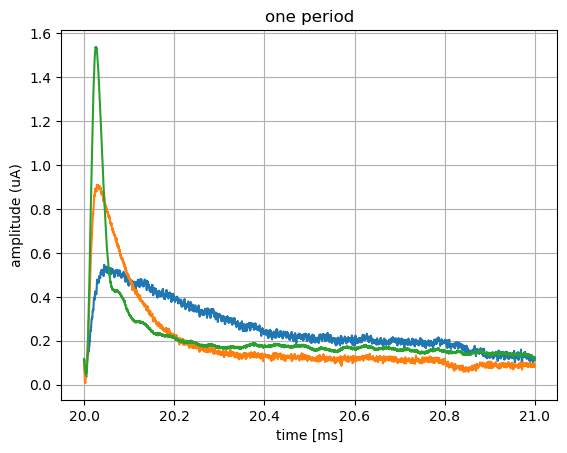

In [1814]:
# trying to get impedance data directly

#Vb = pico_to_ibias(didv('H')[0,:10_000])*didv.config['rsh']*didv.conv['H'] 
Ib = pico_to_ibias(didv('H')[:10_000]) # amps through bias line
ts = didv.ts[:10_000] + 45e-3 #å s

plt.figure()

traces = {}
Vb = {}


for c in channels:

    Vb[c] = didv.config['rsh']*(Ib + abs(didv.config['off' + c])/1e6)

    avg = didv(c).mean(axis=0) 

    #traces[c] = avg.reshape((10, 10_000)).mean(axis = 0) # amps
    #traces[c] = avg[:10_000]
    #traces[c] = didv(c)[0].reshape((10, 10_000)).mean(axis = 0)
    traces[c] = didv(c)[:,:-4].reshape((-1, 10_000)).mean(axis = 0)

    plt.plot(ts*1e3, traces[c]*1e6)

#plt.plot(ts*1e3, Ib*1e6)

plt.grid()
plt.title('one period')
plt.xlabel('time [ms]')
plt.ylabel('amplitude (uA)')

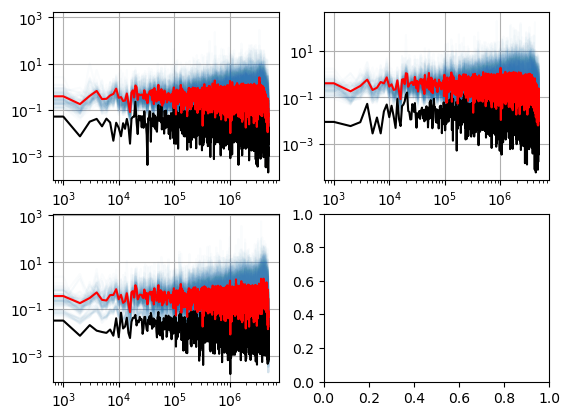

In [1815]:
# frequency space

N = len(ts)
T = (ts[-1] - ts[0])/2

idx, tk, wn = of.get_idx_tk_wn(N, T)

fn = wn/2/np.pi

Vn = {}

Zn = {}

fig, axs = plt.subplots(2, 2)

for ax, c in zip(axs.flatten(), channels):

    Vn[c] = of.fft(Vb[c])

    #all_traces = didv(c).reshape((-1, 10_000))
    all_traces = didv(c)[:,:-4].reshape((-1, 10_000))

    In = of.fft(all_traces, axis = -1)*all_traces.shape[0]
    Zn[c] = (Vn[c]/In).mean(axis = 0)

    ax.loglog()

    for Z in (Vn[c]/In)[:100]:
        ax.plot(fn, abs(Z), alpha = 0.02, color = 'C0')

    ax.plot(fn, abs(Zn[c]), color = 'k')
    ax.plot(fn, (abs(Vn[c]/In)).mean(axis = 0), 'r')

    ax.grid()


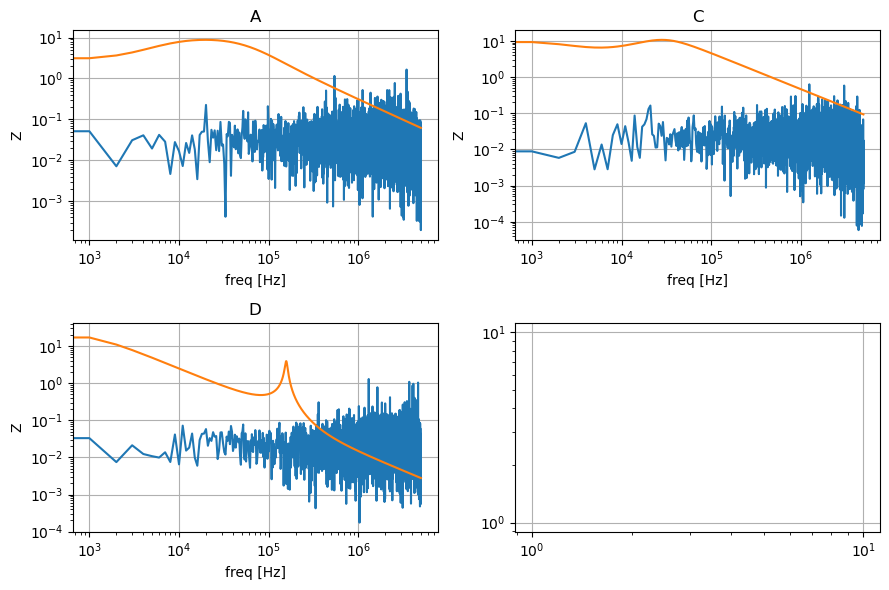

In [1816]:
# impedance plot

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9,6))
for ax in axs.flatten():
    ax.loglog()
    ax.grid()

for c, ax in zip(channels, axs.flatten()):

    ax.plot(fn, abs(Zn[c]))

    fit_params_dict = didvfit[c].fitresult(3)['params']

    A = fit_params_dict['A']
    B = fit_params_dict['B']
    C = fit_params_dict['C']
    tau1 = fit_params_dict['tau1']
    tau2 = fit_params_dict['tau2']
    tau3 = fit_params_dict['tau3']
    dt = fit_params_dict['dt'] 

    Zref = 1/abs(A*(1+1j*wn*tau2) + B/(1 + 1j*wn*tau1 - C/(1 + 1j*wn*tau3)))

    ax.plot(fn, Zref)
    ax.set_title(c)
    ax.set_xlabel('freq [Hz]')
    ax.set_ylabel('Z')

fig.tight_layout()

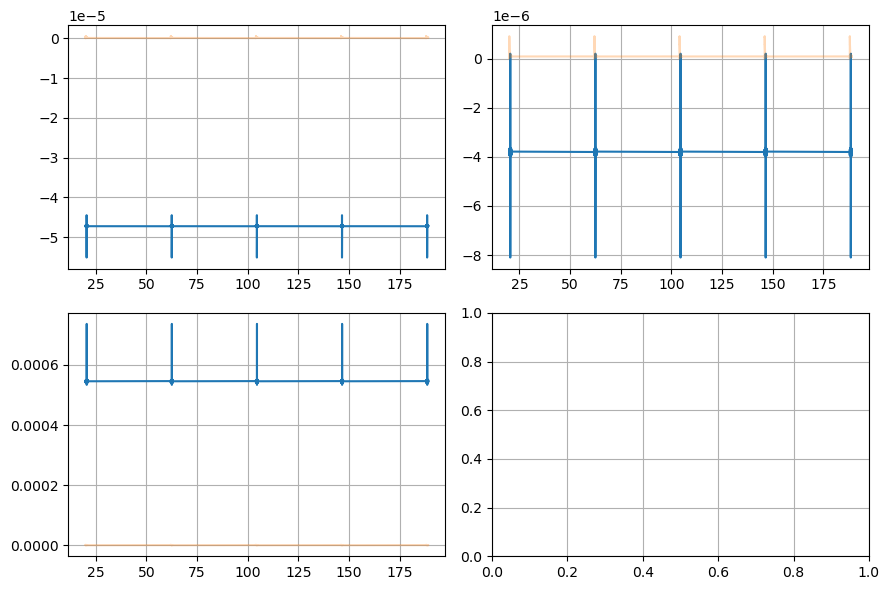

In [1817]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9,6))
for ax in axs.flatten():
    #ax.loglog()
    ax.grid()

for c, ax in zip(channels, axs.flatten()):

    #ax.plot(ts*1e3, traces[c])

    fit_params_dict = didvfit[c].fitresult(3)['params']

    A = fit_params_dict['A']
    B = fit_params_dict['B']
    C = fit_params_dict['C']
    tau1 = fit_params_dict['tau1']
    tau2 = fit_params_dict['tau2']
    tau3 = fit_params_dict['tau3']
    dt = fit_params_dict['dt'] 

    dVdIref = A*(1 + 1j*wn*tau2) + B/(1 + 1j*wn*tau1 - C/(1 + 1j*wn*tau3))

    I0n = (Vn[c])*dVdIref

    I0 = of.ifft(I0n*np.exp(1j*wn*dt)) #+ abs(didv.config['off'+c]/1e6)

    t5 = np.hstack([(2*i*ts[-1]+ts)*1e3 for i in range(5)])

    ax.plot(t5, np.hstack(5*[np.roll(np.real(I0), len(I0)//2)]))
    ax.plot(t5, np.hstack(5*[traces[c]]), alpha = 0.3)

fig.tight_layout()

In [1818]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offA': -194.9,
 'offC': -141.1,
 'offD': -85.5}

In [1819]:
didvfit['C'].fitresult(3)['smallsignalparams'].keys()

dict_keys(['rsh', 'rp', 'r0', 'beta', 'l', 'L', 'tau0', 'gratio', 'tau3', 'dt'])

In [1820]:
for c in channels:
    print(c, traces[c].mean()*1e6, tr_fits[c]['I0'])

A 0.2598886069369669 -192.4
C 0.19219409244691518 -128.4
D 0.22187729364294334 -89.4


In [1821]:
tr_fits[c]['R_op']

np.float64(0.6525155774762871)

In [1822]:
R_ops

array([1.01621743, 0.66246817, 0.2039653 , 0.65251558])

0.4841832159273606 0.02
4.311221884164597 0.02
0.3319888988782246 0.02


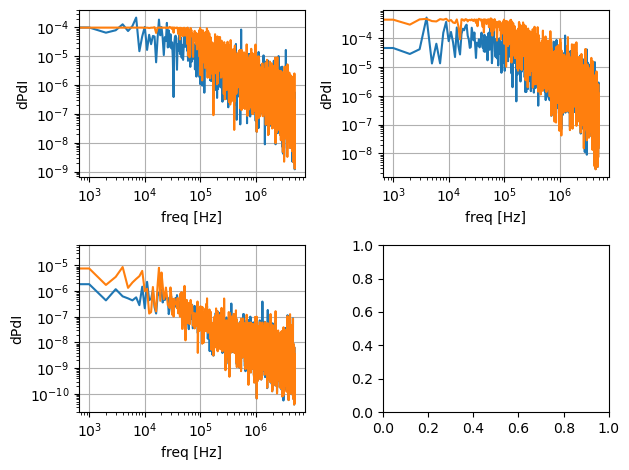

In [1823]:
dpdi_num = {}

fig, axs = plt.subplots(2, 2)


for ax, c in zip(axs.flatten(), channels):

    #all_traces = didv(c).reshape((-1, 10_000))
    
    all_traces = didv(c)[:,:-4].reshape((-1, 10_000))
    In = of.fft(all_traces, axis = -1)*all_traces.shape[0]
    Z = Vn[c]/In

    param_dict = didvfit[c].fitresult(3)['smallsignalparams']

    rsh = param_dict['rsh']
    rp = param_dict['rp']
    r0 = param_dict['r0']
    beta = param_dict['beta']
    l = param_dict['l']
    L = param_dict['L']
    tau0 = param_dict['tau0']
    gratio = param_dict['gratio']
    tau3 = param_dict['tau3']
    dt = param_dict['dt']

    print(rp, rsh)

    dpdi = abs((tr_fits[c]['I0']*1e-6)*r0)*(2 + beta)*Z/(Z - (1j*wn*L + rsh + rp + r0*(1+beta)))

    dpdi2 = abs((tr_fits[c]['I0']*1e-6)*r0)*(2 + beta)*Zn[c]/(Zn[c] - (1j*wn*L + rsh + rp + r0*(1+beta)))

    ax.loglog(fn[N//2:], abs(dpdi2)[N//2:])
    ax.loglog(fn[N//2:], abs(dpdi.mean(axis = 0))[N//2:])

    dpdi_num[c] = dpdi.mean(axis = 0)
    #dpdi_num[c] = dpdi2

    ax.set_xlabel('freq [Hz]')
    ax.set_ylabel('dPdI')
    ax.grid()

fig.tight_layout()
dpdi_num['freq'] = fn

In [1858]:
# save numerical dpdi
if 0:
    savefile = folder_base + f'/Run{runnum}/dIdV Data/{runname}_numerical_dpdi.dat'
    with open(savefile, 'wb') as f:
        pickle.dump(file = f, obj = dpdi_num)
    print('saved data to', savefile)

In [1825]:
fn

array([-5000500.35006505, -4999500.24999503, -4998500.14992502, ...,
        4997500.04985501,  4998500.14992502,  4999500.24999503],
      shape=(10000,))

In [1826]:
for c in channels:
    print(didvfit[c].fitresult(3)['smallsignalparams']['rp'])

0.4841832159273606
4.311221884164597
0.3319888988782246


In [1827]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offA': -194.9,
 'offC': -141.1,
 'offD': -85.5}

In [1828]:
sgamp

0.0034782608695652175

1 C


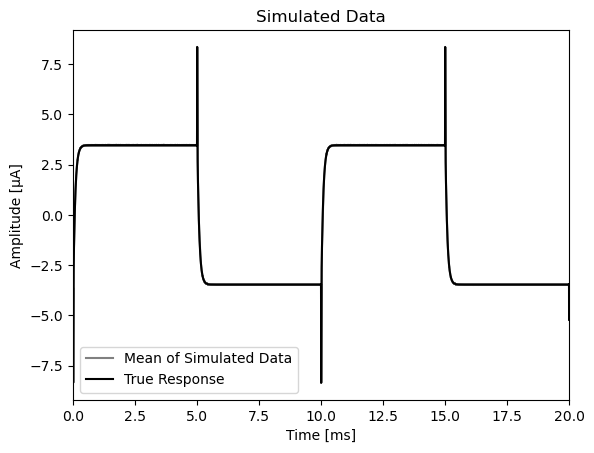

In [1829]:
# stuff from https://github.com/spice-herald/QETpy/blob/master/demos/didv/test_didv.ipynb
# Setting various parameters that are specific to the dataset
fs = 1e6
sgfreq = didv.config['freq']
sgamp = func_to_ibias(didv.config['amp'], n = len(channels))

true_params = {
    'rsh': rsh,
    'rp': 0.006,
    'r0': 0.0756,
    'r0_err':0.001,
    'i0': 100e-6,
    'i0_err': 1e-8,
    'beta': 2,
    'l': 10,
    'L': 1e-7,
    'tau0': 500e-6,
    'gratio': 0.5,
    'tau3': 1e-3,
    'dt': 0
}

fit_params = {
 'A': np.float64(0.11568541897870592),
 'B': np.float64(0.9384846587918997),
 'C': np.float64(-157.2069010657995),
 'tau1': np.float64(0.00041223998164367407),
 'tau2': np.float64(-2.548637390450984e-06),
 'tau3': np.float64(-1.1903936252394476),
 'dt': np.float64(0.005005296146991601)}

chan = 'C'
true_params = didvfit[chan].fitresult(3)['params']
i = channels.find(chan)
true_smallsig_params = qp.DIDV._converttotesvalues(true_params, rsh = didv.config['rsh'], r0 = R_ops[i], rp = ivfits.rp[0,i])
print(i, chan)

n_bins = int(4 * fs / sgfreq)

t = np.arange(n_bins) / fs

didv_response = qp.squarewaveresponse(t, sgamp, sgfreq, true_smallsig_params, dutycycle = 0.5, rsh = rsh)

#true_params = didvfit[chan].fitresult(3)['smallsignalparams']


rawtraces = didv_response + rawnoise

fig, ax = plt.subplots()
ax.plot(t*1e3, rawtraces.mean(axis = 0)*1e6, color = 'gray', label = 'Mean of Simulated Data')
ax.plot(t*1e3, didv_response * 1e6, color='k', label='True Response')

ax.set_ylabel('Amplitude [μA]')
ax.set_xlabel('Time [ms]')
ax.set_title('Simulated Data')
ax.set_xlim(0, 20)
ax.legend()

## Plot against guesses ##

In [1830]:
didvfit['D'].fitresult(3)['params']

{'A': np.float64(0.46071172742107885),
 'B': np.float64(133906935.47932659),
 'C': np.float64(266086767.88546354),
 'tau1': np.float64(4.294985707452275),
 'tau2': np.float64(2.4841755196797318e-05),
 'tau3': np.float64(3.542915457983761e-05),
 'dt': np.float64(0.004951645783728484)}

2 D


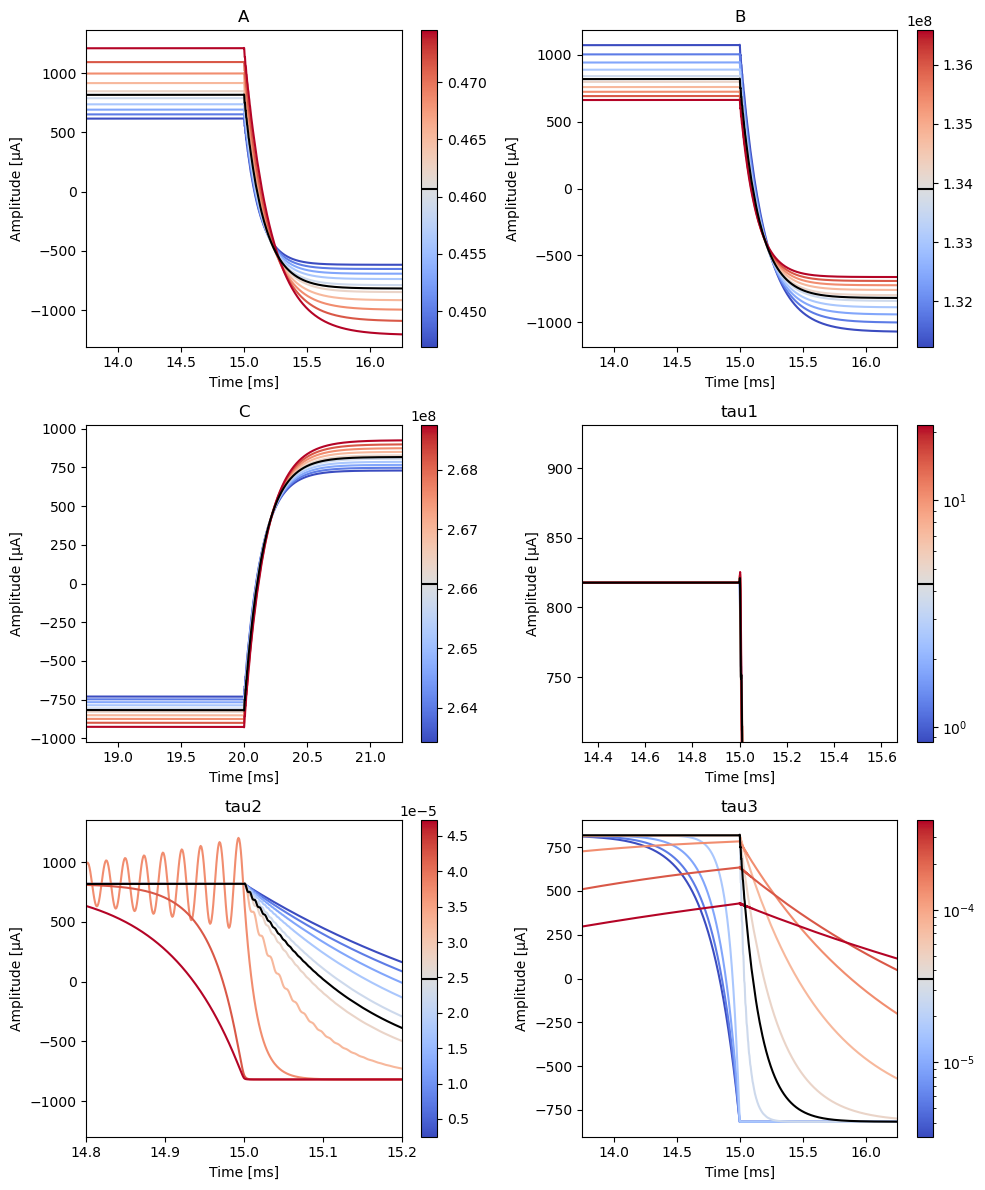

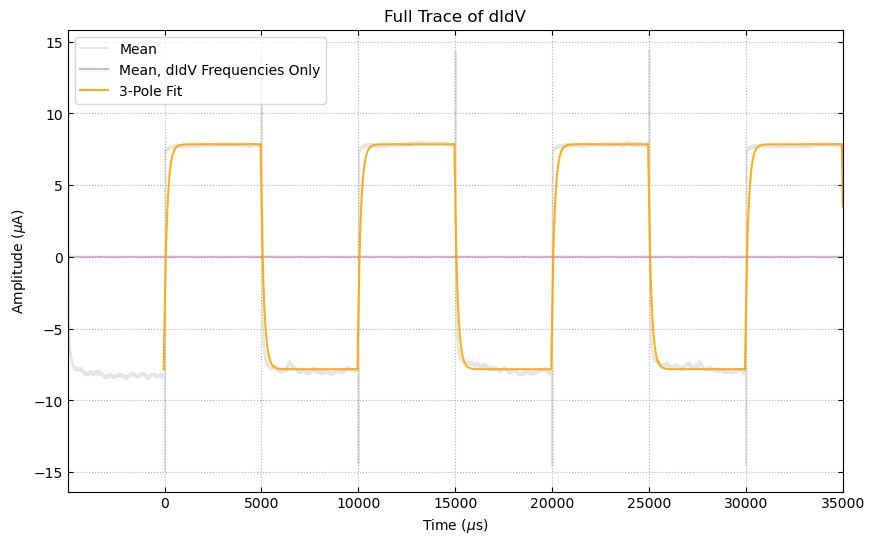

In [1855]:
# stuff from https://github.com/spice-herald/QETpy/blob/master/demos/didv/test_didv.ipynb
# Setting various parameters that are specific to the dataset
fs = 1e6
sgfreq = didv.config['freq']
sgamp = func_to_ibias(didv.config['amp'], n = len(channels))/0.01

true_params = {
 'A': np.float64(0.11568541897870592),
 'B': np.float64(0.9384846587918997),
 'C': np.float64(-657.2069010657995),
 'tau1': np.float64(0.00041223998164367407),
 'tau2': np.float64(-2.548637390450984e-06),
 'tau3': np.float64(-1.1903936252394476),
 'dt': np.float64(0.005005296146991601)}

varscale = {'A': 0.03, 'B': 0.02, 'C': 0.01, 'tau1': 5, 'tau2': 0.9, 'tau3': 10.9}

zoomin = {
          'A':     {'x': (1/4,8), 'y': (0.01,1)},
          'B':     {'x': (1/4,8), 'y': (0,1)},
          'C':     {'x': (1/2,8), 'y': (0,1)},
          'tau1':  {'x': (1/4,15), 'y': (0.45,8)},
          'tau2':  {'x': (1/4,50), 'y': (0.01,1)},
          'tau3':  {'x': (1/4,8), 'y': (0,1)},
         }

chan = 'D'
true_params = didvfit[chan].fitresult(3)['params']
i = channels.find(chan)
true_smallsig_params = qp.DIDV._converttotesvalues(true_params, rsh = didv.config['rsh'], r0 = R_ops[i], rp = ivfits.rp[0,i])
print(i, chan)

n_bins = int(4 * fs / sgfreq)

t = np.arange(n_bins) / fs

didv_response = qp.squarewaveresponse(t, sgamp, sgfreq, true_smallsig_params, dutycycle = 0.5, rsh = rsh)


params_to_plot = list(varscale.keys())
numrows = (1+len(params_to_plot))//2

fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10, numrows*4))


for i, (param, ax) in enumerate(zip(params_to_plot, axs.flatten())):

    param_val = true_params[param]
    var = varscale[param]
    if var < 1:
        paramspace = np.linspace(1-var, 1+var, 10)*param_val
        cnorm = mplcolors.Normalize(vmin = abs(paramspace).min(), vmax = abs(paramspace).max())
    else:
        paramspace = np.geomspace(1/var, var, 10)*param_val
        cnorm = mplcolors.LogNorm(vmin = abs(paramspace).min(), vmax = abs(paramspace).max())

    
    cmap = plt.cm.coolwarm

    for p in paramspace:
        params_mod = true_params.copy()
        params_mod[param] = p
        params_smallsig_mod = qp.DIDV._converttotesvalues(params_mod, rsh = didv.config['rsh'], r0 = R_ops[channels.find(chan)], rp = ivfits.rp[0,channels.find(chan)])
        response_here = qp.squarewaveresponse(t, sgamp, sgfreq, params_smallsig_mod, dutycycle = 0.5, rsh = rsh)

        ax.plot(t*1e3, response_here * 1e6, color=cmap(cnorm(abs(p))))


    ax.plot(t*1e3, didv_response * 1e6, color='k', label='0')
    ax.set_xlim(0, 20)
    if param in zoomin:
        xshift, xzoom = zoomin[param]['x']
        yshift, yzoom = zoomin[param]['y']
        x1, x2, y1, y2 = ax.axis()
        xs = np.array([x1, x2])
        ys = np.array([y1, y2])
        ax.set_xlim(*(xs.mean() + (xs-xs.mean())/xzoom + xshift*(x2-x1)))
        ax.set_ylim(*(ys.mean() + (ys-ys.mean())/yzoom + yshift*(y2-y1)))

    cb = fig.colorbar(plt.cm.ScalarMappable(cmap = cmap, norm = cnorm), ax = ax)
    cwind = cb.ax.axis()
    cb.ax.axhline(param_val, color = 'k')
    cb.ax.axhline(-param_val, color = 'k', linestyle = 'dotted')
    cb.ax.axis(cwind)
    ax.set_ylabel('Amplitude [μA]')
    ax.set_xlabel('Time [ms]')
    #
    ax.set_title(param)
    #ax.legend()

fig.tight_layout()

didvfit[chan].plot_full_trace(didv_freq_filt=True)

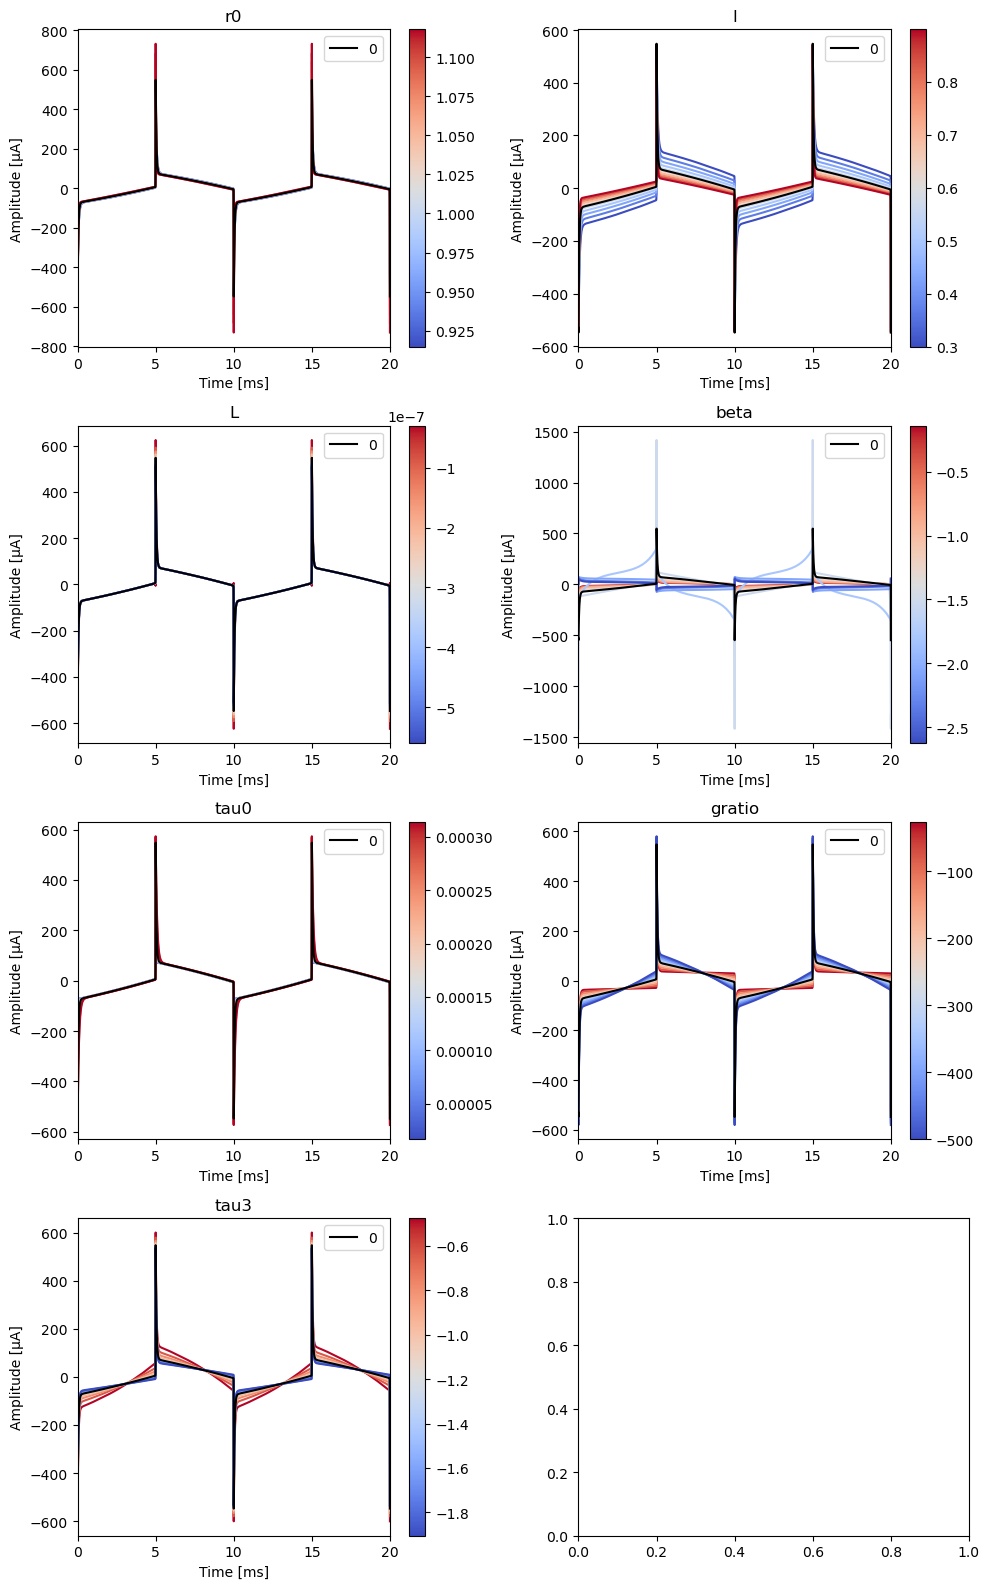

In [1832]:
# stuff from https://github.com/spice-herald/QETpy/blob/master/demos/didv/test_didv.ipynb
# Setting various parameters that are specific to the dataset
fs = 1e6
sgfreq = didv.config['freq']
sgamp = func_to_ibias(didv.config['amp'], n = len(channels))/0.01

true_params = {'rsh': 0.02,
 'rp': np.float64(0.4841832159273606),
 'r0': np.float64(1.0162174290480954),
 'beta': np.float64(-1.3822979077544122),
 'l': np.float64(0.5992096077439553),
 'L': np.float64(-2.948401843391178e-07),
 'tau0': np.float64(0.00016522182394659288),
 'gratio': np.float64(-263.4022116715414),
 'tau3': np.float64(-1.1903936252394476),
 'dt': np.float64(0.005005296146991601)}

chan = 'A'
#true_params = didvfit[chan].fitresult(3)['smallsignalparams']

n_bins = int(4 * fs / sgfreq)
t = np.arange(n_bins) / fs
didv_response = qp.squarewaveresponse(t, sgamp, sgfreq, true_params, dutycycle = 0.5, rsh = rsh)

varscale = {'r0': 0.1, 'l': 0.5, 'L': 0.9, 'beta': 0.9, 'tau0': 0.9, 'gratio': 0.9, 'tau3': 0.6}
params_to_plot = list(varscale.keys())
numrows = (1+len(params_to_plot))//2

fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10, numrows*4))


for i, (param, ax) in enumerate(zip(params_to_plot, axs.flatten())):

    param_val = true_params[param]
    var = varscale[param]
    if var < 1:
        paramspace = np.linspace(1-var, 1+var, 10)*param_val
        cnorm = mplcolors.Normalize(vmin = paramspace.min(), vmax = paramspace.max())
    else:
        paramspace = np.geomspace(1/var, var, 10)*param_val
        cnorm = mplcolors.LogNorm(vmin = paramspace.min(), vmax = paramspace.max())

    
    cmap = plt.cm.coolwarm

    for p in paramspace:
        params_mod = true_params.copy()
        params_mod[param] = p
        response_here = qp.squarewaveresponse(t, sgamp, sgfreq, params_mod, dutycycle = 0.5, rsh = rsh)

        ax.plot(t*1e3, response_here * 1e6, color=cmap(cnorm(p)))


    ax.plot(t*1e3, didv_response * 1e6, color='k', label='0')

    fig.colorbar(plt.cm.ScalarMappable(cmap = cmap, norm = cnorm), ax = ax)
    ax.set_ylabel('Amplitude [μA]')
    ax.set_xlabel('Time [ms]')
    ax.set_xlim(0, 20)
    ax.set_title(param)
    ax.legend()

fig.tight_layout()

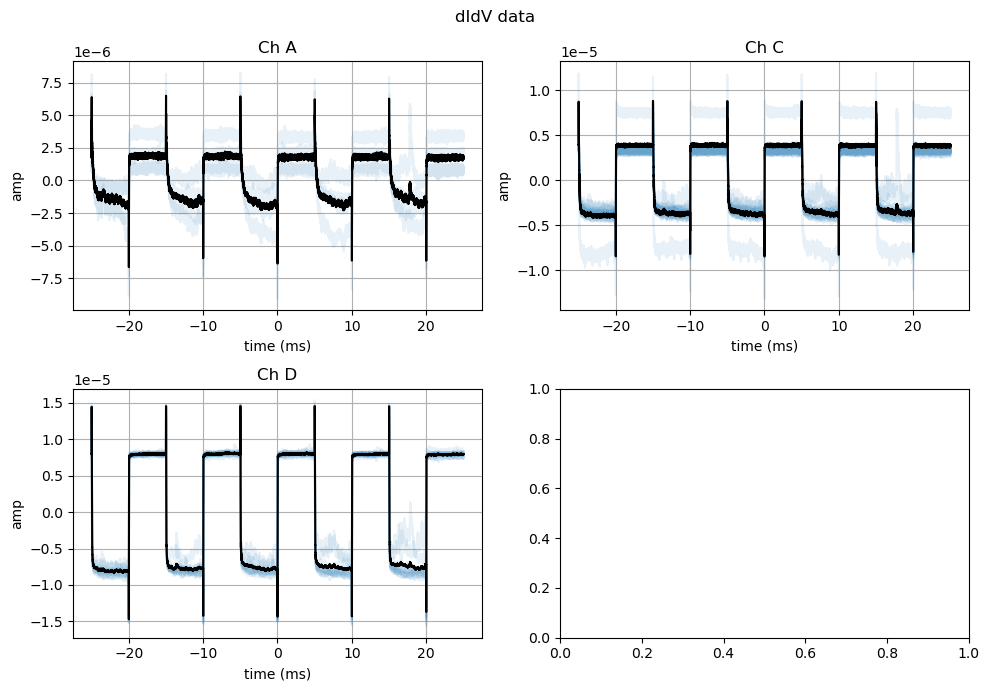

In [1833]:
# plot DIDV data
numrows = (1+len(channels))//2

didv_waveform = didv('H')

fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))

fig.suptitle('dIdV data')


for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

    ax.grid()
    ax.set_ylabel('amp')
    ax.set_xlabel('time (ms)')
    ax.set_title(f'Ch {c}')

    #ax.plot(didv.ts*1e3, didv(c)[5])
    dat = didv(c)
    meandat = dat.mean(axis = 0)

    for i in range(dat.shape[0]):
        ax.plot(didv.ts*1e3, dat[i], alpha = 0.1, color = ('C0' if np.dot(dat[i], meandat) > 0 else 'r' ))
    #ax.plot(didv.ts*1e3, didv('H'), alpha = 0.2)
    #for i in range(10):
    #    ax.axvline(didv.ts[2500 + i*10_000]*1e3)
    #    ax.axvline(didv.ts[7500 + i*10_000]*1e3)
    ax.plot(didv.ts*1e3, meandat, color = 'k')
    #ax.plot(didv.ts[:100_000]*1e3, didv(c)[:100_000])
    #ax.set_ylim(-1e-6, 1e-6)
    #ax.plot(didv.ts*1e3, didv(c))

fig.tight_layout()


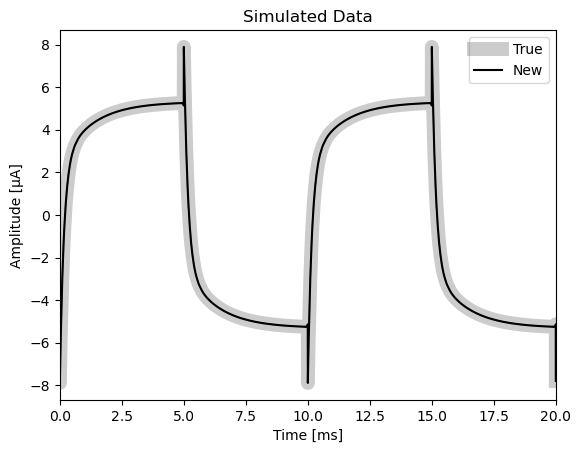

In [1834]:
def plot_a_thing(params):
    fs = 1e6
    sgfreq = didv.config['freq']
    sgamp = func_to_ibias(didv.config['amp'], n = len(channels))

    true_params = {
        'rsh': rsh,
        'rp': 0.006,
        'r0': 0.0756,
        'r0_err':0.001,
        'i0': 100e-6,
        'i0_err': 1e-8,
        'beta': 2,
        'l': 10,
        'L': 1e-7,
        'tau0': 500e-6,
        'gratio': 0.5,
        'tau3': 1e-3,
        'dt': 0
    }

    n_bins = int(4 * fs / sgfreq)
    t = np.arange(n_bins) / fs

    didv_true = qp.squarewaveresponse(
        t, sgamp, sgfreq, true_params, dutycycle=0.5, rsh=rsh
    )

    didv_response = qp.squarewaveresponse(
        t, sgamp, sgfreq, params, dutycycle=0.5, rsh=rsh
    )

    fig, ax = plt.subplots()
    ax.plot(t*1e3, didv_true * 1e6, color='gray', linewidth = 10, alpha = 0.4, label='True')
    ax.plot(t*1e3, didv_true * 1e6, color='gray', linewidth = 1)
    ax.plot(t*1e3, didv_response * 1e6, color='k', label='New')

    ax.set_ylabel('Amplitude [μA]')
    ax.set_xlabel('Time [ms]')
    ax.set_title('Simulated Data')
    ax.set_xlim(0, 20)
    ax.legend()

plot_a_thing({
        'rsh': rsh,
        'rp': 0.006,
        'r0': 0.0756,
        'r0_err':0.001,
        'i0': 100e-6,
        'i0_err': 1e-8,
        'beta': 2,
        'l': 10,
        'L': 1e-7,
        'tau0': 500e-6,
        'gratio': 0.5,
        'tau3': 1e-3,
        'dt': 0
    })

In [1835]:
didvfit['C'].fitresult(3)['params']

{'A': np.float64(0.09377046679723833),
 'B': np.float64(4907184.93422695),
 'C': np.float64(25289620.484983318),
 'tau1': np.float64(423.39970484105584),
 'tau2': np.float64(3.6544531653170124e-06),
 'tau3': np.float64(3.627846531913408e-05),
 'dt': np.float64(0.0050009956276763625)}

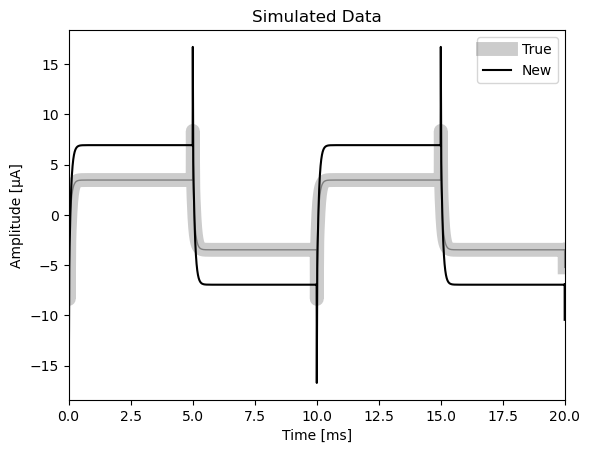

In [1836]:
def plot_a_thing(params, chan = 'D'):
    fs = 1e6
    sgfreq = didv.config['freq']
    sgamp = func_to_ibias(didv.config['amp'], n = len(channels))

    true_params = {
        'A': np.float64(0.09377046679723833),
        'B': np.float64(4907184.93422695),
        'C': np.float64(25289620.484983318),
        'tau1': np.float64(423.39970484105584),
        'tau2': np.float64(3.6544531653170124e-06),
        'tau3': np.float64(3.627846531913408e-05),
        'dt': np.float64(0.0050009956276763625)
    }

    n_bins = int(4 * fs / sgfreq)
    t = np.arange(n_bins) / fs

    true_smallsig_params = qp.DIDV._converttotesvalues(true_params, rsh = didv.config['rsh'], r0 = R_ops[channels.find(chan)], rp = ivfits.rp[0,channels.find(chan)])
    smallsig_params = qp.DIDV._converttotesvalues(params, rsh = didv.config['rsh'], r0 = R_ops[channels.find(chan)], rp = ivfits.rp[0,channels.find(chan)])

    didv_true = qp.squarewaveresponse(
        t, sgamp, sgfreq, true_smallsig_params, dutycycle=0.5, rsh=rsh
    )

    didv_response = qp.squarewaveresponse(
        t, sgamp, sgfreq, smallsig_params, dutycycle=0.5, rsh=rsh
    )

    fig, ax = plt.subplots()
    ax.plot(t*1e3, didv_true * 1e6, color='gray', linewidth = 10, alpha = 0.4, label='True')
    ax.plot(t*1e3, didv_true * 1e6, color='gray', linewidth = 1)
    ax.plot(t*1e3, didv_response * 1e6, color='k', label='New')

    ax.set_ylabel('Amplitude [μA]')
    ax.set_xlabel('Time [ms]')
    ax.set_title('Simulated Data')
    ax.set_xlim(0, 20)
    ax.legend()

plot_a_thing({
    'A': np.float64(0.09377046679723833/2),
    'B': np.float64(4907184.93422695/2),
    'C': np.float64(25289620.484983318),
    'tau1': np.float64(423.39970484105584),
    'tau2': np.float64(3.6544531653170124e-06),
    'tau3': np.float64(3.627846531913408e-05),
    'dt': np.float64(0.0050009956276763625)
    }, chan = 'C')